## Visualization

In [213]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Tuple, Optional
from dataclasses import dataclass
from enum import Enum
from matplotlib.animation import FuncAnimation


@dataclass
class MatplotlibVizConfig:
    # config for scientific visualization with matplotlib and save as svg
    figsize: Tuple[int, int] = (10, 10)
    dpi: int = 100
    background_color: str = "white"
    font_size: int = 20
    font_family: str = "Arial"
    font_color: str = "black"
    linewidth: int = 2  
    show_grid: bool = True
    use_tex: bool = True
    legend_loc: str = "upper right"
    title: str = ""
    hide_empty_plots: bool = True

    


class PlotOn(Enum):
    APPEND_RIGHT = "append_right"
    APPEND_DOWN = "append_down"
    RIGHT = "right"


class PlotType(Enum):
    LINE = "line"
    SCATTER = "scatter"
    BAR = "bar"
    HIST = "hist"
    IMAGE = "image"


@dataclass
class Plot:
    X: np.ndarray
    y: Optional[np.ndarray]
    plot_type: PlotType
    plot_order: PlotOn
    plot_row_col: Tuple[int, int] = (-1, -1)
    title: str = ""
    title_size: int = 7
    xlabel: str = ""
    ylabel: str = ""
    label_size: int = 10
    color: str = "blue"
    marker: Optional[str] = None
    linestyle: str = "-"
    linewidth: int = 2
    legend: str = ""
    show_legend: bool = True
    legend_size: int = 7
    apply_margin: bool = False
    top_margin: float = 0.9
    bottom_margin: float = 0.1
    left_margin: float = 0.1
    right_margin: float = 0.9
    xmax: Optional[float] = None
    xmin: Optional[float] = None
    ymax: Optional[float] = None
    ymin: Optional[float] = None
    allow_animation: bool = True
    



class MatplotlibVisualizer:
    def __init__(self, config: MatplotlibVizConfig):
        self.config = config
        self._plots = []
        self.curr_row = 0
        self.curr_col = 0
        self.num_rows=1
        self.num_cols=1
        self.num_plots = 0
        self.ax_lim = {}

    def make_figure(self):
        print(f"Making figure with {self.num_rows} rows and {self.num_cols} columns.")        
        fig, ax = plt.subplots(
            self.num_rows,
            self.num_cols,
            figsize=self.config.figsize,
            dpi=self.config.dpi,
            facecolor=self.config.background_color,
            
        )
        fig.suptitle(self.config.title, fontsize=self.config.font_size, fontfamily=self.config.font_family, color=self.config.font_color)
        plt.tight_layout()
        # use latex on text
        if self.config.use_tex:
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
        return fig, np.array(ax).reshape(self.num_rows, self.num_cols)

    def append_plot(
        self,
        plot: Plot,
        left_to_right: bool = True,
    ):
        if self.num_plots == 0:
            self.num_plots += 1
        else:
            if plot.plot_order == PlotOn.APPEND_RIGHT:
                if left_to_right:
                    self.curr_col += 1
            elif plot.plot_order == PlotOn.APPEND_DOWN:
                self.curr_row += 1
                if left_to_right:
                    self.curr_col = 0
            elif plot.plot_order == PlotOn.RIGHT:
                pass
            else:
                raise ValueError("Invalid plot order.")
            self.num_plots += 1
            self.num_rows = max(self.num_rows, self.curr_row + 1)
            self.num_cols = max(self.num_cols, self.curr_col + 1)

        
            
        plot.plot_row_col = (self.curr_row, self.curr_col)

        if plot.X is not None:
            if plot.xmax is None:
                plot.xmax = np.nanmax(plot.X)
            if plot.xmin is None:
                plot.xmin = np.nanmin(plot.X)
            if plot.plot_type == PlotType.IMAGE:
                plot.xmax = plot.X.shape[1]
                plot.xmin = 0
        if plot.y is not None:
            if plot.ymax is None:
                plot.ymax = np.nanmax(plot.y)
            if plot.ymin is None:
                plot.ymin = np.nanmin(plot.y)
        
        self._plots.append(plot)

    def _generate_plot(self, plot: Plot, ax, legend_loc: dict = {}, limit:int=-1):
        curr_row, curr_col = plot.plot_row_col
        key =f'{curr_row}_{curr_col}'
        if plot.plot_type == PlotType.LINE:
            ax.plot(plot.X[:limit], plot.y[:limit], color=plot.color, marker=plot.marker, linestyle=plot.linestyle, linewidth=plot.linewidth)
        elif plot.plot_type == PlotType.SCATTER:
            ax.scatter(plot.X[:limit], plot.y[:limit], color=plot.color, marker=plot.marker, linewidth=plot.linewidth)
        elif plot.plot_type == PlotType.BAR:
            ax.bar(plot.X[:limit], plot.y[:limit], color=plot.color)
        elif plot.plot_type == PlotType.HIST:
            ax.hist(plot.X[:limit], color=plot.color)
        elif plot.plot_type == PlotType.IMAGE:
            ax.imshow(plot.X)
        else:
            raise ValueError("Invalid plot type.")

        
        # add left margin
        # print(ax.get_xlim(), ax.get_ylim())
        x_min, x_max = plot.xmin, plot.xmax #ax.get_xlim()
        y_min, y_max = plot.ymin, plot.ymax #ax.get_ylim()
        
        if self.ax_lim.get(key) is None:
            self.ax_lim[key] = []
        else:
            # print(f"Existing limits: {self.ax_lim[key]}, keys: {key}")
            x_min = min(x_min, self.ax_lim[key][0]) if (self.ax_lim[key][0] is not None and x_max is not None) else ax.get_xlim()[0]
            x_max = max(x_max, self.ax_lim[key][1]) if (self.ax_lim[key][1] is not None and x_max is not None) else ax.get_xlim()[1]
            y_min = min(y_min, self.ax_lim[key][2]) if (self.ax_lim[key][2] is not None and y_min is not None) else ax.get_ylim()[0]
            y_max = max(y_max, self.ax_lim[key][3]) if (self.ax_lim[key][3] is not None and y_max is not None) else ax.get_ylim()[1]
        self.ax_lim[key]=[x_min, x_max, y_min, y_max]

        if plot.apply_margin:
            ax.set_xlim([x_min - plot.left_margin, x_max + plot.right_margin])
            if plot.y is not None:
                ax.set_ylim([y_min - plot.bottom_margin, y_max + plot.top_margin])
        
        ax.set_title(plot.title, fontsize=plot.title_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.set_xlabel(plot.xlabel, fontsize=plot.label_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.set_ylabel(plot.ylabel, fontsize=plot.label_size, fontfamily=self.config.font_family, color=self.config.font_color)
        ax.grid(self.config.show_grid)
        if plot.show_legend:
            if plot.legend!='':    
                curr_row, curr_col = plot.plot_row_col
                if legend_loc.get(key) is None:
                    legend_loc[key]=[]
                legend_loc[key].append(plot.legend)
        return ax, legend_loc

    def generate_plots(self, save_path: Optional[Path] = None, format: str = "svg"):        
        # get figure and axes
        fig, ax = self.make_figure()
        
        legend_loc = {}

       
        for plot in self._plots:
            curr_row, curr_col = plot.plot_row_col     
            curr_ax = ax[curr_row, curr_col]
            
            curr_ax, legend_loc = self._generate_plot(plot, curr_ax, legend_loc, limit=plot.X.shape[0])
            
        for rc, loc in legend_loc.items():
            curr_row, curr_col = [int(i) for i in rc.split("_")]
            curr_ax = ax[curr_row, curr_col]
            curr_ax.legend(legend_loc[rc], loc=self.config.legend_loc, fontsize=plot.legend_size)
            
        # hide empty plots
        if self.config.hide_empty_plots:
            plot_row_col = [plot.plot_row_col for plot in self._plots]
            for i in range(self.num_rows):
                for j in range(self.num_cols):
                    if (i, j) not in plot_row_col:
                        ax[i, j].axis("off")
        
        if save_path is not None:
            self.save_fig(fig, save_path, format=format)


        return fig, ax

    def _animate(self, i, ax, num_frames=30):
        legend_loc = {}

        for plot in self._plots:
            curr_row, curr_col = plot.plot_row_col
            curr_ax = ax[curr_row, curr_col]

            if plot.allow_animation:
                limit = int(i * len(plot.X) / num_frames)
            else:
                limit = len(plot.X)

            curr_ax, legend_loc = self._generate_plot(plot, curr_ax, legend_loc, limit=limit)
            
        for rc, loc in legend_loc.items():
            curr_row, curr_col = [int(i) for i in rc.split("_")]
            curr_ax = ax[curr_row, curr_col]
            curr_ax.legend(legend_loc[rc], loc=self.config.legend_loc, fontsize=plot.legend_size)
            
        # hide empty plots
        if self.config.hide_empty_plots:
            plot_row_col = [plot.plot_row_col for plot in self._plots]
            for i in range(self.num_rows):
                for j in range(self.num_cols):
                    if (i, j) not in plot_row_col:
                        ax[i, j].axis("off")
        
        return ax
    
    def animate_plots(self, interval: int = 10, frames: int = 10, save_path: Optional[Path] = None):
        fig, ax = self.make_figure()
        anim = FuncAnimation(fig, self._animate, frames=frames, fargs=(ax, frames,), interval=interval)
        if save_path is not None:
            self.save_animation(anim, save_path)
        return anim
    
    def save_animation(self, anim, path: Path):
        anim.save(path)

    def save_fig(self, fig, path: Path, format: str = "svg"):
        fig.savefig(path, format=format, dpi=self.config.dpi)

    def show_fig(self):
        plt.show()

    def close_fig(self, fig):
        plt.close(fig)
    
    def clear_plots(self):
        self._plots = []
        self.num_plots = 0
        self.curr_row = 0
        self.curr_col = 0
        self.num_rows=1
        self.num_cols=1
        plt.clf()
    

Making figure with 3 rows and 2 columns.


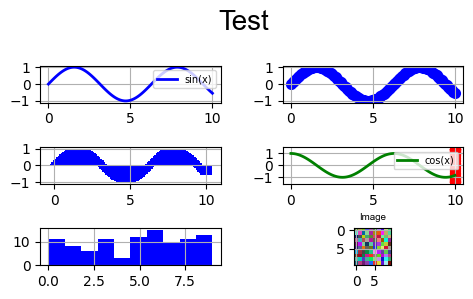

In [214]:
viz_config = MatplotlibVizConfig(figsize=(5,3),title="Test",
                                 use_tex=False,)
viz = MatplotlibVisualizer(config=viz_config)

X = np.linspace(0, 10, 100)
y = np.sin(X)
z = np.cos(X)
w = y+z

# show legend in latex format

plot1 = Plot(X=X, y=y, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="sin(x)")
plot2 = Plot(X=X, y=y, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_RIGHT)
plot3 = Plot(X=X, y=y, plot_type=PlotType.BAR, plot_order=PlotOn.APPEND_DOWN)
plot4 = Plot(X=X, y=z, plot_type=PlotType.LINE, plot_order=PlotOn.APPEND_RIGHT, legend="cos(x)", color="green", allow_animation=False)
plot5 = Plot(X=np.array([1]*100), y=w, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, legend="sin(x)+cos(x)", color="red")
plot5 = Plot(X=np.array([10]*100), y=w, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, legend="", color="red", allow_animation=False)

plot6 = Plot(X=np.random.randint(0, 10, 100), y=None, plot_type=PlotType.HIST, plot_order=PlotOn.APPEND_DOWN)
plot7 = Plot(X=np.random.randint(0, 255,(10,10, 3)), y=None, plot_type=PlotType.IMAGE, plot_order=PlotOn.APPEND_RIGHT, title="Image")


viz.append_plot(plot1)
viz.append_plot(plot2)
viz.append_plot(plot3)
viz.append_plot(plot4)
viz.append_plot(plot5)
viz.append_plot(plot6)
viz.append_plot(plot7)


fig, ax = viz.generate_plots()
viz.save_fig(fig, Path("expt_res/test.png"), 'png')
viz.show_fig()
# viz.close_fig(fig)
# print(ax)

MovieWriter imagemagick unavailable; using Pillow instead.


Making figure with 3 rows and 2 columns.


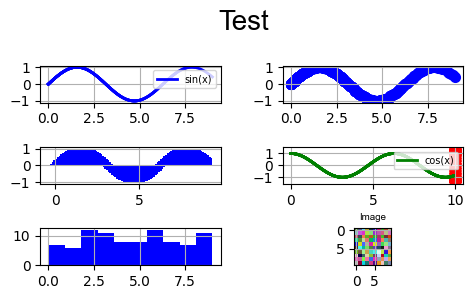

In [73]:
viz.animate_plots(interval=100,frames=10).save('expt_res/test.gif', writer='imagemagick', fps=30)

## Loss

In [4]:
from enum import Enum
import numpy as np


class LossType(Enum):
    MSE = "mean_squared_error"
    MAE = "mean_absolute_error"
    HINGE = "hinge"
    RMSE = "root_mean_squared_error"


class Loss:
    def __init__(self, loss_type: LossType):
        self.loss_type = loss_type
        self.name = loss_type.value

    def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        if self.loss_type == LossType.MSE:
            return self.mean_squared_error(y_true, y_pred)
        elif self.loss_type == LossType.MAE:
            return self.mean_absolute_error(y_true, y_pred)
        elif self.loss_type == LossType.HINGE:
            return self.hinge(y_true, y_pred)
        elif self.loss_type == LossType.RMSE:
            return self.mean_squared_error(y_true, y_pred)**0.5
        else:
            raise ValueError(f"Loss type {self.loss_type} not supported")

    def mean_squared_error(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return ((y_true - y_pred) ** 2).mean()

    def mean_absolute_error(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return (y_true - y_pred).abs().mean()

    def hinge(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return (1 - y_true * y_pred).clip(min=0).mean()


## Experiment

In [217]:
import torch.nn as nn
from typing import List
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
from dataclasses import asdict, field

from gradls.vis.colors import visible_colors

class DataGenerator:
    def __init__(self, num_rows:int, num_cols:int, min_val:int=0, max_val:int=100, 
                 weights:Optional[np.ndarray]=None, biases:Optional[np.ndarray]=None,
                 seed:int=100, normalize:bool=True):
        np.random.seed(seed)
        self.X = np.random.uniform(min_val, max_val+1, (num_rows, num_cols))
        self.normalize = normalize
        if normalize:
            self.X = self.X/np.max(self.X)
        self.weights = weights
        self.biases = biases
    
    def make_data(self):
        if self.weights is None:
            self.weights = np.random.randn(self.X.shape[1])
        if self.biases is None:
            self.biases = np.random.randn(1)
        
        

        self.y = np.dot(self.X, self.weights) + self.biases
        self.X, self.y = torch.tensor(self.X, dtype=torch.float32), torch.tensor(self.y, dtype=torch.float32)
        return self.X, self.y

class Optimizer(Enum):
    SGD = "sgd"
    ADAM = "adam"
    RMSPROP = "rmsprop"
    ADAGRAD = "adagrad"
    ADADELTA = "adadelta"

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            raise ValueError("No y values found. Please generate data first.")
        return self.X[idx], self.y[idx]

@dataclass
class ExperimentConfig:
    name: str
    viz_config: MatplotlibVizConfig
    num_epochs:int
    batch_size:int
    loss:LossType
    model:Optional[nn.Module]=None
    optimizer:Optimizer=Optimizer.SGD
    learning_rate:float=0.01
    momentum:float=0.0
    train_valid_split:float=0.1
    seed:Optional[int]=100
    metrics:List[LossType]=field(default_factory=lambda:[LossType.MAE])
    log_every:int=1
    log_dir:Path=None
    log_anim:bool=True
    anim_interval:int=100 
    anim_frames:int=10
    anim_fps:int=30
    log_real_params:bool=True

class Runner:
    def __init__(self, name:str, model:nn.Module, batch_size:int, optimizer:str, loss:Loss, 
                 metrics:Optional[List[Loss]]=[], log_every:int=1, log_params:bool=False,
                 is_test:bool=False, data:Dataset=None, l1_penalty:float=0.0, l2_penalty:float=0.0):
        self.name = name
        self.batch_size = batch_size
        self.metrics = metrics
        self.loss = loss
        self.optimizer = optimizer
        self.model = model
        self.is_test = is_test
        self.data_loader = DataLoader(data, batch_size=64, shuffle=True)
        self.logs = {metric.name:[] for metric in self.metrics}
        self.logs[f"{name}_loss({loss.name})"] = []
        self.curr_epoch = 0
        self.log_every = log_every
        self.log_params = log_params
        self.logs['epochs']=[]
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
        if log_params:
            self.logs['weights']=[]
            self.logs['biases']=[]
            self.logs['gradients']=[]
            self.logs['learning_rate']=[]
        
    
    def step(self):
        if self.is_test:
            self.model.eval()
        else:
            self.model.train()
        
        batch_losses = []
        batch_metrics = {metric.name:[] for metric in self.metrics}
        # print(self.metrics)
        
        # all_preds = []

        for i, (X, y) in enumerate(self.data_loader):
            # print(f"Epoch {self.curr_epoch}, Batch {i}, ")
            
            y_pred = self.model(X)
            
            # if self.log_output:
            #     all_preds.extend(y_pred.detach().numpy().tolist())

            loss = self.loss(y, y_pred.squeeze())
            batch_losses.append(loss.item())

            params = torch.cat([p.view(-1) for p in self.model.parameters()])
            
            if self.l1_penalty > 0:
                loss += self.l1_penalty * torch.abs(params).sum()
            if self.l2_penalty > 0:
                loss += self.l2_penalty * (params**2).sum()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            for metric in self.metrics:
                batch_metrics[metric.name].append(metric(y, y_pred).detach().numpy())

        if self.curr_epoch % self.log_every == 0:    
            epoch_loss = np.mean(batch_losses)
            epoch_metrics = {metric.name:np.mean(batch_metrics[metric.name]) for metric in self.metrics}
            self.logs[f"{self.name}_loss({self.loss.name})"].append(epoch_loss)
            for metric in self.metrics:
                self.logs[metric.name].append(epoch_metrics[metric.name])
            
            self.logs['epochs'].append(self.curr_epoch)

            if self.log_params:
                self.logs['weights'].append(self.model.weight.data.numpy().copy())
                self.logs['biases'].append(self.model.bias.data.numpy().copy())
                self.logs['gradients'].append(self.model.weight.grad.data.numpy().copy())
                self.logs['learning_rate'].append(self.optimizer.param_groups[0]['lr'])
        self.curr_epoch += 1

        # if self.log_output:
        #     self.predictions.append(all_preds)

        return epoch_loss, epoch_metrics


class Experiment:
    def __init__(self, config: ExperimentConfig):
        if config.seed is None:
            config.seed = np.random.randint(0, 100) 
        torch.manual_seed(config.seed)
        self.config = config
        self.viz_config = config.viz_config
        self.viz = MatplotlibVisualizer(config=self.viz_config)
        self.losses = {}
        self.metrics = {metric.value:[] for metric in self.config.metrics}
        self.optimizer = None
        self.real_weights = None
        self.real_biases = None
        
        self.loss_fxn = Loss(self.config.loss)       
        
    
    def load_data(self, data:DataGenerator):
        self.data = data
        X, y = data.make_data()
        self.real_weights = data.weights
        self.real_biases = data.biases
                
        if self.config.model is None:
            self.config.model = nn.Linear(in_features=X.shape[1], out_features=1)

        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=self.config.train_valid_split, random_state=self.config.seed)
        self.train_X, self.val_X, self.train_y, self.val_y = train_X, val_X, train_y, val_y
        self.make_runners()
    
    def make_runners(self):
        train_data = MyDataset(self.train_X, self.train_y)
        val_data = MyDataset(self.val_X, self.val_y)

        if self.config.optimizer == Optimizer.SGD:
            self.optimizer = torch.optim.SGD(self.config.model.parameters(), lr=self.config.learning_rate, momentum=self.config.momentum)
        elif self.config.optimizer == Optimizer.ADAM:
            self.optimizer = torch.optim.Adam(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.RMSPROP:
            self.optimizer = torch.optim.RMSprop(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.ADAGRAD:
            self.optimizer = torch.optim.Adagrad(self.config.model.parameters(), lr=self.config.learning_rate)
        elif self.config.optimizer == Optimizer.ADADELTA:
            self.optimizer = torch.optim.Adadelta(self.config.model.parameters(), lr=self.config.learning_rate)
        else:
            raise ValueError("Invalid optimizer type.")

        self.train_loader = DataLoader(train_data, batch_size=self.config.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_data, batch_size=self.config.batch_size, shuffle=False)
        self.train_runner = Runner(name="train",loss=self.loss_fxn, model=self.config.model, batch_size=self.config.batch_size, optimizer=self.optimizer, 
                                   metrics=[Loss(m) for m in self.config.metrics], data=train_data, log_params=True)
        self.val_runner = Runner(name="val", loss=self.loss_fxn,model=self.config.model, batch_size=self.config.batch_size, optimizer=self.optimizer, 
                                 metrics=[Loss(m) for m in self.config.metrics], is_test=True, data=val_data)
    

    def train(self):
        try:
            self.train_loader
        except AttributeError:
            raise ValueError("Setup the experiment first.")
        for epoch in range(self.config.num_epochs):
            train_loss, train_metrics = self.train_runner.step()
            val_loss, val_metrics = self.val_runner.step()
            self.losses[epoch] = {"train_loss":train_loss, "val_loss":val_loss}
            for metric in self.config.metrics:
                self.metrics[metric.value].append({"train":train_metrics[metric.value], "val":val_metrics[metric.value]})
            
            # train_mse, val_mse, train_bias, val_bias, train_variance, val_variance = self.calculate_bias_variance()

            if epoch % self.config.log_every == 0:
                print(f"Epoch {epoch}: Train Loss: {train_loss}, Val Loss: {val_loss}")
            

        print("Training complete.")
            
    def get_default_plots(self, plot_parameters:bool=True)->List[Plot]:
        plots = []
        colors = visible_colors
        keys = list(colors.values())
        # np.random.shuffle(keys)
        train_loss = np.array([m["train_loss"] for m in self.losses.values()])
        val_loss = np.array([m["val_loss"] for m in self.losses.values()])
        plots.append(Plot(X=np.arange(self.config.num_epochs), y=train_loss, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="train_loss", color=keys[0]))
        plots.append(Plot(X=np.arange(self.config.num_epochs), y=val_loss, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend="val_loss", color=keys[1]))

        for metric in self.config.metrics:
            train_metric = np.array([m["train"] for m in self.metrics[metric.value]])
            val_metric = np.array([m["val"] for m in self.metrics[metric.value]])
            
            plots.append(Plot(X=np.arange(len(train_metric)), y=train_metric, plot_type=PlotType.LINE, plot_order=PlotOn.APPEND_RIGHT, legend=f"train_{metric.value}", color=keys[2]))
            plots.append(Plot(X=np.arange(len(val_metric)), y=val_metric, plot_type=PlotType.LINE, plot_order=PlotOn.RIGHT, legend=f"val_{metric.value}", color=keys[3]))

        if plot_parameters and self.train_runner.log_params:
            epochs = np.array(self.train_runner.logs['epochs'])
            weights = np.array(self.train_runner.logs['weights']).reshape(len(epochs), -1)
            biases = np.array(self.train_runner.logs['biases']).reshape(len(epochs), -1)
            gradients = np.array(self.train_runner.logs['gradients']).reshape(len(epochs), -1)
            

            weights_plots = []
            biases_plots = []
            gradients_plots = []
            real_weights = self.real_weights
            
            for widx in range(weights.shape[1]):
                weight = weights[:, widx].flatten()
                gradient = gradients[:, widx].flatten()
                color = keys[len(colors)%(widx+1)]
                if widx == 0:
                    weights_plots.append(Plot(X=epochs, y=weight, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_DOWN, title='Weights', color=color))
                    # if self.config.log_real_params:
                    #     weights_plots.append(Plot(X=epochs, y=real_weights[widx]*np.ones_like(epochs), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, marker='x',
                    #                             color=color, allow_animation=False))
                    gradients_plots.append(Plot(X=epochs, y=gradient, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_RIGHT, title='Gradients', color=color))
                else:
                    weights_plots.append(Plot(X=epochs, y=weight, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, color=color, title='Weights', xlabel='Epoch'))
                    # if self.config.log_real_params:
                    #     weights_plots.append(Plot(X=epochs, y=real_weights[widx]*np.ones_like(epochs), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, marker='x',
                    #                           color=color, allow_animation=False))
                    gradients_plots.append(Plot(X=epochs, y=gradient, plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, color=color, xlabel='Epoch', title='Gradients'))

            bc=keys[np.random.randint(0, len(colors))]
            biases_plots.extend([Plot(X=epochs, y=[b.flatten() for b in biases], plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_RIGHT, 
                                     title='Biases', xlabel='Epoch', color=bc, legend='Trained Bias'),
                                    #  Plot(X=epochs, y=[self.real_biases]*np.ones_like(epochs), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, marker='x', 
                                    #  title='Biases', xlabel='Epoch', legend='Real Bias', color=bc, allow_animation=False)
                                     ])
            

            # if self.config.log_real_params:
            #     weights_plots[-1].legend='Real Weights'
            weights_plots[-2].legend='Trained Weights'
            weights_plots[-1].xlabel='Epoch'

            gradients_plots[-1].legend='Gradients'

            plots.extend(weights_plots)
            plots.extend(biases_plots)
            plots.extend(gradients_plots)
            if self.config.log_real_params:
                plots.extend([
                    Plot(X=np.arange(len(real_weights)), y=real_weights, plot_type=PlotType.SCATTER, plot_order=PlotOn.APPEND_RIGHT, 
                                   title='Real Parameters', legend='Real Weights',color=keys[4], allow_animation=False), 
                            Plot(X=np.array([int(len(real_weights)//2)]), y=np.array([self.real_biases[0]]), plot_type=PlotType.SCATTER, plot_order=PlotOn.RIGHT, legend='Real Bias', linewidth=10, 
                                 marker='+', color=keys[10], allow_animation=False)])
            

        print(f"Found {len(plots)} metrics to plot.")
        return plots    
    
        
    def animate_plots(self, interval: int = 10, frames: int = 10):
        return self.viz.animate_plots(interval, frames)
    
    def save_fig(self, fig, path: Path, format: str = "svg"):
        self.viz.save_fig(fig, path, format)
    
    def show_fig(self):
        self.viz.show_fig()
    
    def log_expt(self, format:str='png', plots:Optional[List[Plot]]=None)->Path:        

        if plots is None:
            plots = self.get_default_plots()
        self.viz.clear_plots()
        for plot in plots:
            self.viz.append_plot(plot)
        fig, ax = self.viz.generate_plots()
        
        if self.config.log_dir is None:
            self.config.log_dir = Path("expt_res")
        expt_dir = Path(f"{self.config.log_dir}/{self.config.name}")
        expt_dir.mkdir(parents=True, exist_ok=True)

        # log expt config
        expt_config = asdict(self.config)
        np.save(Path(f"{self.config.log_dir}/{self.config.name}_config.npy"), expt_config)


        self.save_fig(fig, Path(f"{expt_dir}/{self.config.name}.{format}"), format=format)

        if self.config.log_anim:
            self.animate_plots(interval=self.config.anim_interval, frames=self.config.anim_frames).save(Path(f"{expt_dir}/{self.config.name}.gif"), 
                                                                                                        writer='imagemagick', fps=self.config.anim_fps)
        print(f"Experiment results saved at {expt_dir}.")

        # store train and val data as numpy files
        np.save(Path(f"{expt_dir}/train_X.npy"), self.train_X.numpy())
        np.save(Path(f"{expt_dir}/train_y.npy"), self.train_y.numpy())
        np.save(Path(f"{expt_dir}/val_X.npy"), self.val_X.numpy())
        np.save(Path(f"{expt_dir}/val_y.npy"), self.val_y.numpy())
        print("Data saved.")

        # store all logs from runners
        logs = {key:runner.logs for key, runner in zip(['train', 'val'], [self.train_runner, self.val_runner])}
        np.save(Path(f"{expt_dir}/logs.npy"), logs)
        print("Logs saved.")
        # store real weights and biases
        np.save(Path(f"{expt_dir}/real_weights.npy"), self.real_weights)
        np.save(Path(f"{expt_dir}/real_biases.npy"), self.real_biases)
        print("Real weights and biases saved.")
        # store all params from model, no need its in experiment config
        # torch.save(self.config.model.state_dict(), Path(f"{expt_dir}/model.pth"))
        # print("Model saved.")

        # store all losses and metrics
        np.save(Path(f"{expt_dir}/losses.npy"), self.losses)
        np.save(Path(f"{expt_dir}/metrics.npy"), self.metrics)
        print("Losses and metrics saved.")
        return expt_dir


in_features = 20
out_features = 1
viz_config = MatplotlibVizConfig(figsize=(15,10),title="My Exp",
                                 use_tex=False)
exp_config = ExperimentConfig(name="My Exp", loss=LossType.MSE, viz_config=viz_config, 
                              num_epochs=100, batch_size=1,learning_rate=0.01, optimizer=Optimizer.ADAM,
                              model=None, metrics=[LossType.MAE, LossType.HINGE, LossType.RMSE],
                              log_every=1, log_anim=True, anim_fps=10)

data = DataGenerator(num_rows=1000, num_cols=in_features, weights=None, biases=None, max_val=100, 
                     normalize=True, seed=exp_config.seed)

exp = Experiment(config=exp_config)
exp.load_data(data)
exp.train()


Epoch 0: Train Loss: 6.31176970799764, Val Loss: 3.582322359085083
Epoch 1: Train Loss: 1.6498176813125611, Val Loss: 1.3094092011451721
Epoch 2: Train Loss: 1.0909513235092163, Val Loss: 1.2430358827114105
Epoch 3: Train Loss: 1.12417129278183, Val Loss: 1.0827339589595795
Epoch 4: Train Loss: 0.9493767301241557, Val Loss: 1.1215294003486633
Epoch 5: Train Loss: 0.876729017496109, Val Loss: 1.0703608095645905
Epoch 6: Train Loss: 0.8589349746704101, Val Loss: 0.9456646144390106
Epoch 7: Train Loss: 0.8315169135729472, Val Loss: 0.9262891709804535
Epoch 8: Train Loss: 0.7843567570050557, Val Loss: 0.8853810429573059
Epoch 9: Train Loss: 0.6910919557015102, Val Loss: 0.8236744105815887
Epoch 10: Train Loss: 0.6850287914276123, Val Loss: 0.7634193599224091
Epoch 11: Train Loss: 0.6227770308653514, Val Loss: 0.6806730031967163
Epoch 12: Train Loss: 0.5650972406069438, Val Loss: 0.6126135587692261
Epoch 13: Train Loss: 0.5409807165463766, Val Loss: 0.5814513564109802
Epoch 14: Train Loss: 

Found 51 metrics to plot.
Making figure with 2 rows and 4 columns.
Making figure with 2 rows and 4 columns.


MovieWriter imagemagick unavailable; using Pillow instead.


Experiment results saved at expt_res\My Exp.
Data saved.
Logs saved.
Real weights and biases saved.
Losses and metrics saved.


WindowsPath('expt_res/My Exp')

<Figure size 640x480 with 0 Axes>

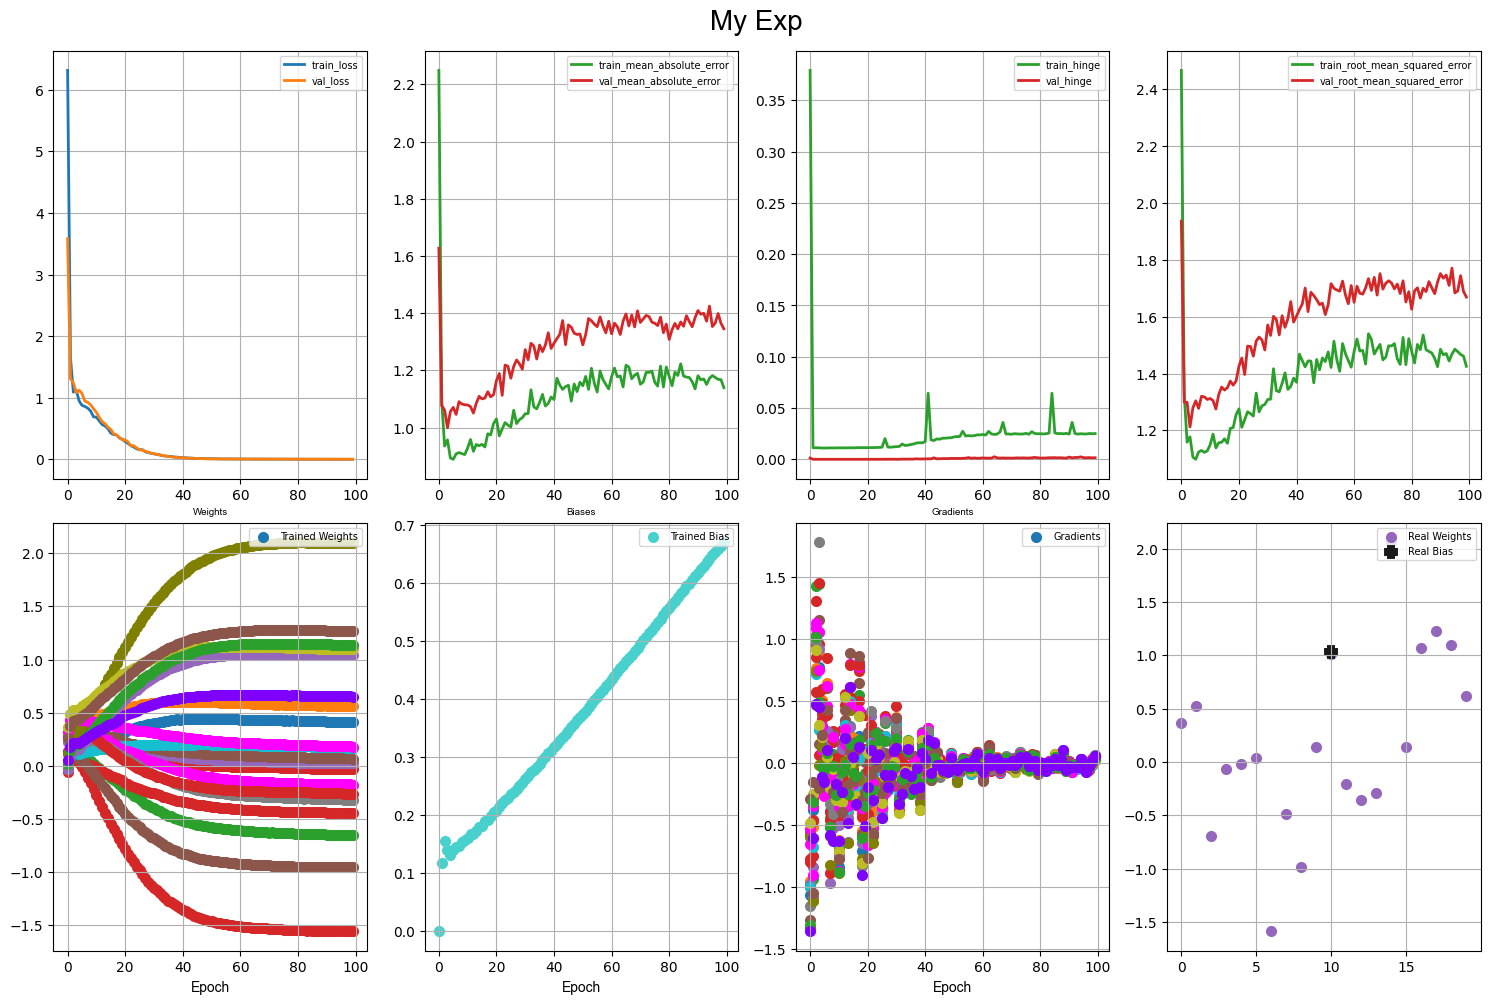

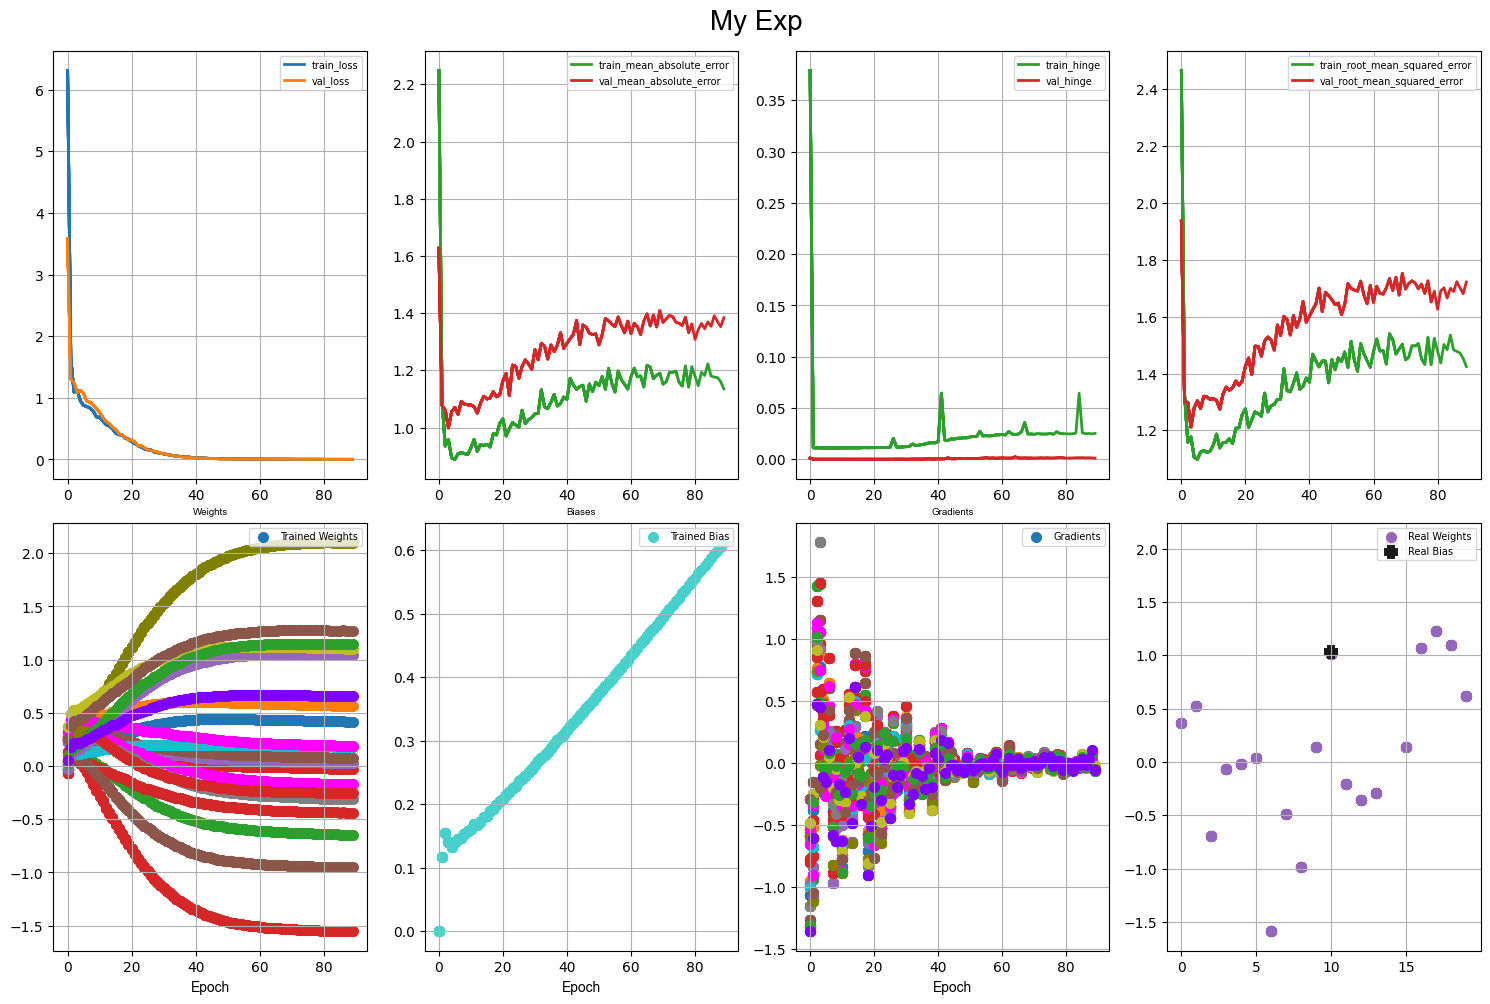

In [218]:
exp.log_expt()

(Parameter containing:
 tensor([[2.0206, 3.0522]], requires_grad=True),
 Parameter containing:
 tensor([3.3814], requires_grad=True))